In [1]:
import os
 
print("username:" , os.getlogin())
from datetime import date

today = date.today()
print("Today's date:", today)

username: Usuario
Today's date: 2023-11-27


In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.config("spark.executor.memory", "8g")\
.config("spark.executor.cores", "10")\
.config("spark.driver.memory", "8g")\
.config("spark.executor.instances", "4")\
.getOrCreate()

In [4]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Users\Usuario\Downloads\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
import os
os.getcwd()

'C:\\Users\\Usuario\\Documents\\DataScience\\BAN5753\\Week13'

In [6]:
from platform import python_version

print(python_version())

3.9.12


In [7]:
sc.version #spark version

'3.5.0'

# Load the data

In [8]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [9]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

# EDA

In [10]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



## Explore correlations between variables 

In [11]:
numeric_features = [col[0] for col in df.dtypes if col[1] != 'string']
numeric_features_df = df.select([col("`{}`".format(col_name)) for col_name in numeric_features])

In [12]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


#### euribor3m has a very high correlation with emp.var.rate and nr.employed. So I decided to drop it from the df

In [13]:
df=df.drop("euribor3m", "emp.var.rate")

## Check for null values

In [14]:
from pyspark.sql.functions import isnan, when, count, col
df = df.toDF(*(col_name.replace(".", "_") for col_name in df.columns))
df.select([count(when(isnan(col(c)), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons_price_idx,cons_conf_idx,nr_employed,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df.select([count(when(isnan(col(c)), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+--------------+-------------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|cons_price_idx|cons_conf_idx|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+--------------+-------------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|             0|            0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+--------------+-------------+-----------+---+



In [16]:
# add the number of missing values as a dictionary and print it out

Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'cons_price_idx': 0,
 'cons_conf_idx': 0,
 'nr_employed': 0,
 'y': 0}

## Statistics

In [17]:
# convert to dataframe

df = df.toDF(*(col_name.replace(".", "_") for col_name in df.columns))

In [18]:
numeric_features = [col[0] for col in df.dtypes if col[1] != 'string']
df.select(numeric_features).describe().toPandas()

,summary,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed
0,count,41188,41188,41188,41188,41188,41188,41188,41188
1,mean,40.02406040594348,258.2850101971448,2.567592502670681,962.4754540157328,0.17296299893172767,93.5756643682899,-40.502600271918276,5167.035910943957
2,stddev,10.421249980934043,259.27924883646455,2.770013542902331,186.910907344741,0.49490107983928927,0.5788400489540823,4.628197856174573,72.25152766826338
3,min,17,0,1,0,0,92.201,-50.8,4963.6
4,max,98,4918,56,999,7,94.767,-26.9,5228.1


## Bivariate analysis

In [19]:
# convert dataset to a Pandas dataframe

df.toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons_price_idx,cons_conf_idx,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,94.767,-50.8,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,94.767,-50.8,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,94.767,-50.8,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,94.767,-50.8,4963.6,yes


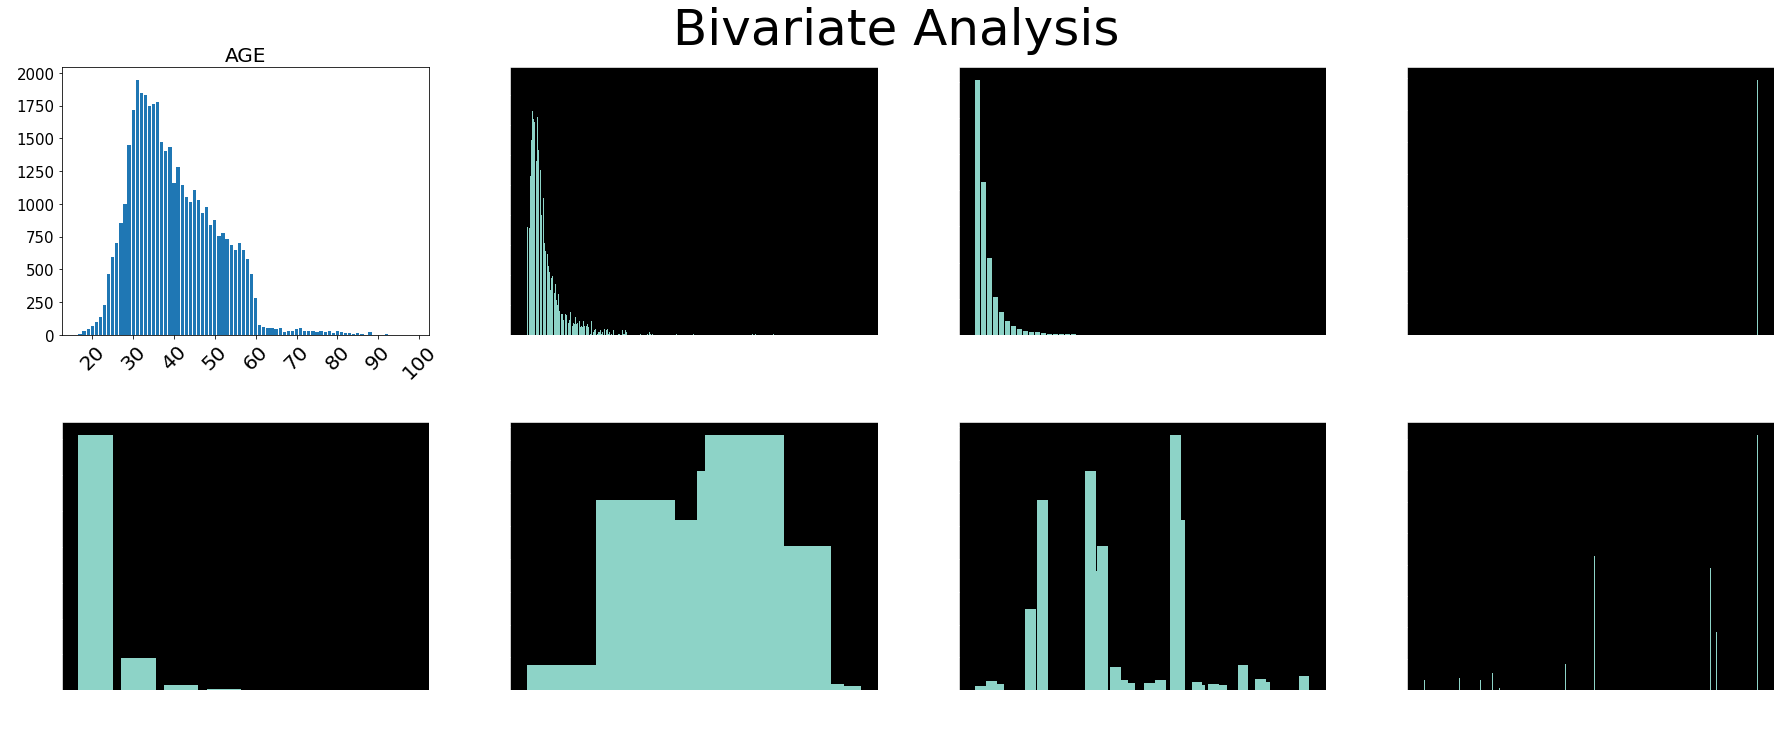

In [20]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Bivariate Analysis", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.bar(df.toPandas()[col].value_counts().index, df.toPandas()[col].value_counts().values)
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)

plt.tight_layout() # to make sure that the bottom of the bar charts are not truncated
plt.show()

# Data processing

In [21]:
df2=df

In [22]:
columns_to_index = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]

output_columns = [f"{col}_index" for col in columns_to_index]

In [23]:
# apply StringIndex

indexers = [StringIndexer(inputCol=col, outputCol=output_col) for col, output_col in zip(columns_to_index, output_columns)]

In [24]:
index_model = [indexer.fit(df2) for indexer in indexers]
index_df = df2

for model in index_model:
    index_df = model.transform(index_df)

In [25]:
index_df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|cons_price_idx|cons_conf_idx|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telep

In [26]:
columns_to_drop = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]

In [27]:
index_df=index_df.drop(*columns_to_drop)

In [28]:
index_df.show(4)

+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|age|duration|campaign|pdays|previous|cons_price_idx|cons_conf_idx|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| 56|     261|       1|  999|       0|        93.994|        -36.4|     5191.0| no|      8.0|          0.0|            4.0|          0.0|          1.0|       0.0|          1.0|        0.0|              1.0|           0.0|
| 57|     149|       1|  999|       0|        93.994|        -36.4|     5191.0| no|      3.0|          0.0|     

In [29]:
# convert the dataset to a Pandas dataframe

index_df.toPandas()

,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,y,job_index,marital_index,education_index,default_index,housing_index,loan_index,contact_index,month_index,day_of_week_index,poutcome_index
0,56,261,1,999,0,93.994,-36.4,5191.0,no,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,57,149,1,999,0,93.994,-36.4,5191.0,no,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,37,226,1,999,0,93.994,-36.4,5191.0,no,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40,151,1,999,0,93.994,-36.4,5191.0,no,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,56,307,1,999,0,93.994,-36.4,5191.0,no,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,94.767,-50.8,4963.6,yes,5.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0
41184,46,383,1,999,0,94.767,-50.8,4963.6,no,1.0,0.0,3.0,0.0,1.0,0.0,0.0,4.0,4.0,0.0
41185,56,189,2,999,0,94.767,-50.8,4963.6,no,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0
41186,44,442,1,999,0,94.767,-50.8,4963.6,yes,2.0,0.0,3.0,0.0,1.0,0.0,0.0,4.0,4.0,0.0


In [30]:
# assemble all predictors as a VectorAssembler

assembler = VectorAssembler()\
         .setInputCols (["age","duration","campaign","cons_price_idx","cons_conf_idx",
                         "pdays","previous","nr_employed","job_index","marital_index","education_index",\
                         "default_index","housing_index","loan_index","contact_index","month_index","day_of_week_index","poutcome_index"])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df = assembler.setHandleInvalid("skip").transform(index_df)
assembler_df.toPandas().head()

,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,y,job_index,marital_index,education_index,default_index,housing_index,loan_index,contact_index,month_index,day_of_week_index,poutcome_index,vectorized_features
0,56,261,1,999,0,93.994,-36.4,5191.0,no,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"[56.0, 261.0, 1.0, 93.994, -36.4, 999.0, 0.0, ..."
1,57,149,1,999,0,93.994,-36.4,5191.0,no,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,"[57.0, 149.0, 1.0, 93.994, -36.4, 999.0, 0.0, ..."
2,37,226,1,999,0,93.994,-36.4,5191.0,no,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"[37.0, 226.0, 1.0, 93.994, -36.4, 999.0, 0.0, ..."
3,40,151,1,999,0,93.994,-36.4,5191.0,no,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"[40.0, 151.0, 1.0, 93.994, -36.4, 999.0, 0.0, ..."
4,56,307,1,999,0,93.994,-36.4,5191.0,no,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,"[56.0, 307.0, 1.0, 93.994, -36.4, 999.0, 0.0, ..."


In [31]:
# standardize the vectorized_features

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model = scaler.fit(assembler_df)

assembler_df = scaler_model.transform(assembler_df)
pd.set_option('display.max_colwidth', 40)

# assembler_df.select("vectorized_features","features").toPandas().head(5)
assembler_df.toPandas().head(5)

,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,y,job_index,...,education_index,default_index,housing_index,loan_index,contact_index,month_index,day_of_week_index,poutcome_index,vectorized_features,features
0,56,261,1,999,0,93.994,-36.4,5191.0,no,8.0,...,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"[56.0, 261.0, 1.0, 93.994, -36.4, 99...","[5.373635610167063, 1.00663667135437..."
1,57,149,1,999,0,93.994,-36.4,5191.0,no,3.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,"[57.0, 149.0, 1.0, 93.994, -36.4, 99...","[5.469593388920046, 0.57466997713333..."
2,37,226,1,999,0,93.994,-36.4,5191.0,no,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,"[37.0, 226.0, 1.0, 93.994, -36.4, 99...","[3.550437813860381, 0.87164707941029..."
3,40,151,1,999,0,93.994,-36.4,5191.0,no,0.0,...,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,"[40.0, 151.0, 1.0, 93.994, -36.4, 99...","[3.8383111501193308, 0.5823836681015..."
4,56,307,1,999,0,93.994,-36.4,5191.0,no,3.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,"[56.0, 307.0, 1.0, 93.994, -36.4, 99...","[5.373635610167063, 1.18405156362372..."


In [33]:
# K-means Clustering
    # reference: https://stackoverflow.com/questions/47585723/kmeans-clustering-in-pyspark

# determine the optimal number of clusters "k" using the Silhouette Method
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores = {}
for k in range(2, 10):
    kmeans = KMeans(featuresCol='features', k=k, seed=5753)
    model = kmeans.fit(assembler_df)
    predictions = model.transform(assembler_df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    silhouette_scores[k] = silhouette

optimal_k = max(silhouette_scores, key=silhouette_scores.get)

print("The optimal number of clusters found using the Silhouette method: ", optimal_k)

The optimal number of clusters found using the Silhouette method:  2


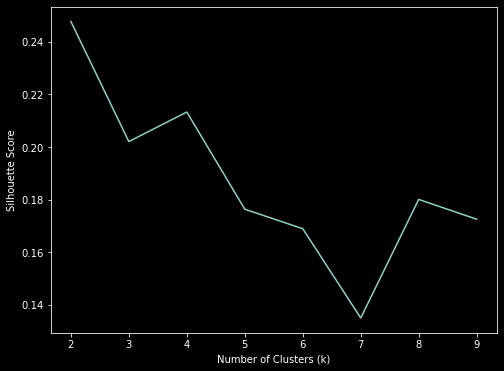

In [34]:
# Plot the silhouette scores
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
## because the highest Silhouette Score is about 0.25, which means that the clusters are poorly defined.
    # therefore, the cluster labels are not included in the subsequent predictive modeling procedures.

In [35]:
# fit KMeans model
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=optimal_k, seed=1)  # 3 clusters here
kmeans_model = kmeans.fit(assembler_df.select('features'))

# add the cluster assignments of observations to the dataframe
df_kmeans = kmeans_model.transform(assembler_df)

# in df_kmeans, rename the "prediction" column as "cluster"
df_kmeans_rev = df_kmeans.withColumnRenamed('prediction', 'cluster')

# show the k-means clustering results
df_kmeans_rev.show(5)

+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+-------+
|age|duration|campaign|pdays|previous|cons_price_idx|cons_conf_idx|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index| vectorized_features|            features|cluster|
+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+-------+
| 56|     261|       1|  999|       0|        93.994|        -36.4|     5191.0| no|      8.0|          0.0|            4.0|          0.0|          1.0|       0.0|          1.0|        

In [36]:
# verify the number of clusters
df_kmeans_rev.groupby("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|24876|
|      0|16312|
+-------+-----+



In [38]:
# for the k-means clustering results ("cluster" column in df_kmeans), examine the summary statistics of each cluster

# split df_kmeans_rev into three dataframes based on the clusters
df_kmeans_rev_cluster_0 = df_kmeans_rev.filter(df_kmeans_rev.cluster == 0)
df_kmeans_rev_cluster_1 = df_kmeans_rev.filter(df_kmeans_rev.cluster == 1)
#df_kmeans_rev_cluster_2 = df_kmeans_rev.filter(df_kmeans_rev.cluster == 2)

In [39]:
# create summary statistics of each cluster

# list numeric features for creating the summary statistics
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx', 'nr_employed']

# create summary statistics of cluster 0
cluster_0 = df_kmeans_rev_cluster_0.select(numeric_features).describe().toPandas()

# add a cluster column with value of 1 & subset the "mean" row
cluster_0['cluster'] = 1
cluster_0_mean = cluster_0.loc[[1]]

cluster_0_mean

,summary,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,cluster
1,mean,39.81774153997058,267.6933545855812,2.0298553212359,906.7750735654732,0.43673369298675824,93.05403236880801,-42.524540215794076,5094.805407063224,1


In [40]:
# create summary statistics of cluster 1
cluster_1 = df_kmeans_rev_cluster_1.select(numeric_features).describe().toPandas()

# add a cluster column with value of 2 & subset the "mean" row
cluster_1['cluster'] = 2
cluster_1_mean = cluster_1.loc[[1]]

cluster_1_mean

,summary,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,cluster
1,mean,40.159350377874254,252.11565364206464,2.920204212895964,999.0,0.0,93.91771538833862,-39.17674867340338,5214.399794980675,2


In [41]:
# concatenate these three mean dataframes & drop the "summary" column

#df_cluster_summary = pd.concat([cluster_0_mean, cluster_1_mean, cluster_2_mean])

df_cluster_summary = pd.concat([cluster_0_mean, cluster_1_mean])

df_cluster_summary

,summary,age,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,cluster
1,mean,39.81774153997058,267.6933545855812,2.0298553212359,906.7750735654732,0.43673369298675824,93.05403236880801,-42.524540215794076,5094.805407063224,1
1,mean,40.159350377874254,252.11565364206464,2.920204212895964,999.0,0.0,93.91771538833862,-39.17674867340338,5214.399794980675,2


In [42]:
# check the data type

df_cluster_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 1
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   summary         2 non-null      object
 1   age             2 non-null      object
 2   duration        2 non-null      object
 3   campaign        2 non-null      object
 4   pdays           2 non-null      object
 5   previous        2 non-null      object
 6   cons_price_idx  2 non-null      object
 7   cons_conf_idx   2 non-null      object
 8   nr_employed     2 non-null      object
 9   cluster         2 non-null      int64 
dtypes: int64(1), object(9)
memory usage: 176.0+ bytes


In [43]:
# convert columns to numeric

num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx', 'nr_employed']

for col in num_cols:
    df_cluster_summary[col] = pd.to_numeric(df_cluster_summary[col], errors='coerce')

df_cluster_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 1
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   summary         2 non-null      object 
 1   age             2 non-null      float64
 2   duration        2 non-null      float64
 3   campaign        2 non-null      float64
 4   pdays           2 non-null      float64
 5   previous        2 non-null      float64
 6   cons_price_idx  2 non-null      float64
 7   cons_conf_idx   2 non-null      float64
 8   nr_employed     2 non-null      float64
 9   cluster         2 non-null      int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 176.0+ bytes


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'cat_col' is your categorical column
# 'num_col1' and 'num_col2' are your numerical columns

# numerical columns
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx', 'nr_employed']

# categorical column
cat_col = 'cluster'

df_grouped = df_cluster_summary.groupby(cat_col).sum()

df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1 to 2
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2 non-null      float64
 1   duration        2 non-null      float64
 2   campaign        2 non-null      float64
 3   pdays           2 non-null      float64
 4   previous        2 non-null      float64
 5   cons_price_idx  2 non-null      float64
 6   cons_conf_idx   2 non-null      float64
 7   nr_employed     2 non-null      float64
dtypes: float64(8)
memory usage: 144.0 bytes


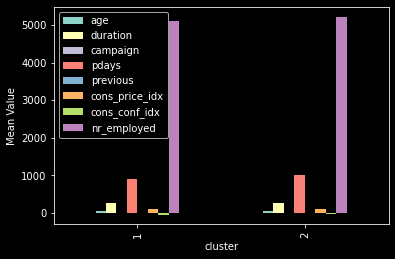

In [45]:
# create a bar chart showing the mean values based on clusters

import matplotlib.pyplot as plt

# numerical columns
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx', 'nr_employed']

# categorical column
cat_col = 'cluster'

# create bar chart
df_cluster_summary.groupby(cat_col)[num_cols].mean().plot(kind='bar')
plt.ylabel('Mean Value')
plt.show()

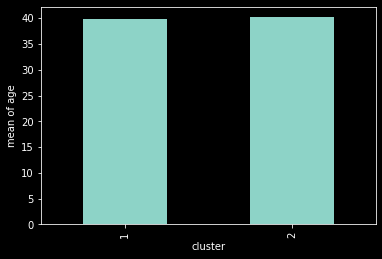

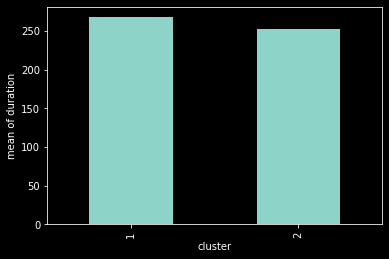

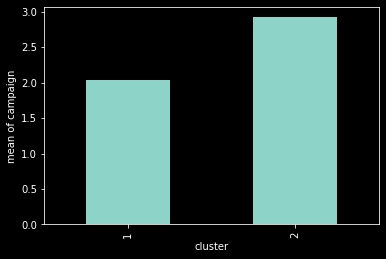

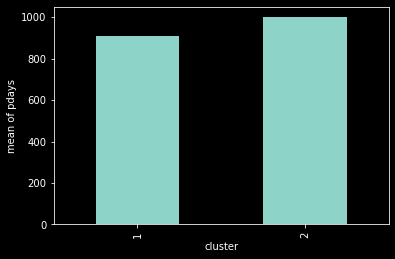

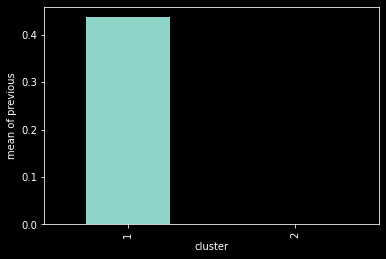

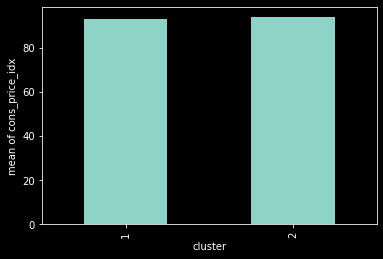

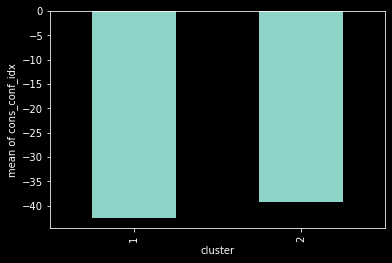

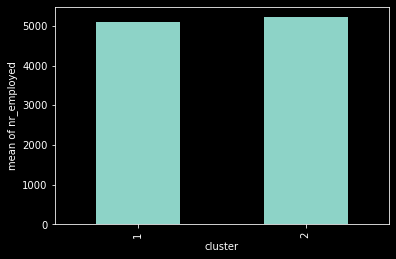

In [46]:
# considering the drastically different scales of the numerical columns,
    # create a bar chart for each of the numerical columns with the bars being grouped by the three clusters

# Group by the categorical column and calculate the mean of the numerical columns
df_cluster_summary_grouped = df_cluster_summary.groupby(cat_col).mean()

# Create separate bar charts for each numerical column
for col in num_cols:
    df_cluster_summary_grouped[col].plot(kind='bar')
    plt.ylabel("mean of " + col)
    plt.show()

In [ ]:
### Build 4 models to predict "y" and select the best model

In [47]:
# convert the target ("y") into numerical values using StringIndexer and rename it to "label"

from pyspark.ml.feature import StringIndexer

# Assuming that df is your DataFrame and "target" is your binary target column
indexer_y = StringIndexer(inputCol="y", outputCol="label")
assembler_df_indexed = indexer_y.fit(assembler_df).transform(assembler_df)

assembler_df_indexed.show(5)

+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+-----+
|age|duration|campaign|pdays|previous|cons_price_idx|cons_conf_idx|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index| vectorized_features|            features|label|
+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+-----+
| 56|     261|       1|  999|       0|        93.994|        -36.4|     5191.0| no|      8.0|          0.0|            4.0|          0.0|          1.0|       0.0|          1.0|        0.0|  

In [48]:
# check if the target is balanced
assembler_df_indexed.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|36548|
|  1.0| 4640|
+-----+-----+



In [49]:
# as shown above, the target variable is quite unbalanced. 
    # therefore, a "weights" column is created to add weights to the models to accommodate the unbalanced target

from pyspark.sql.functions import when

# Calculate the balance ratio
balance_ratio = assembler_df_indexed.filter(assembler_df_indexed['label'] == 0).count() / assembler_df_indexed.count()

# Create a new weights column
assembler_df_indexed = assembler_df_indexed.withColumn('weights', when(assembler_df_indexed.label == 0, balance_ratio).otherwise(1-balance_ratio))

assembler_df_indexed.show(4)

+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+-----+------------------+
|age|duration|campaign|pdays|previous|cons_price_idx|cons_conf_idx|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index| vectorized_features|            features|label|           weights|
+---+--------+--------+-----+--------+--------------+-------------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+-----+------------------+
| 56|     261|       1|  999|       0|        93.994|        -36.4|     5191.0| no|      8.0|          0.0|            4.0|          

In [50]:
# train-test split for modeling (which will create two dataframes)

train, test = assembler_df_indexed.randomSplit([0.8, 0.2], seed = 2023)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

# check the distribution of y in the train and test data
train.groupby("label").count().show()
test.groupby("label").count().show()

Training Dataset Count: 32943
Test Dataset Count: 8245
+-----+-----+
|label|count|
+-----+-----+
|  0.0|29201|
|  1.0| 3742|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7347|
|  1.0|  898|
+-----+-----+



In [51]:
# verify column names to be used in the model
print(assembler_df_indexed.columns)

['age', 'duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx', 'nr_employed', 'y', 'job_index', 'marital_index', 'education_index', 'default_index', 'housing_index', 'loan_index', 'contact_index', 'month_index', 'day_of_week_index', 'poutcome_index', 'vectorized_features', 'features', 'label', 'weights']


In [52]:
# Model 1: logistic regression
    # dataframe: assembler_df_indexed
    # X: "features"
    # y: "label"
    # weights column to accommodate unbalanced target: "weights"

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [53]:
# without weights for accommodating unbalanced target
lr_without_weights = LogisticRegression(featuresCol='features', labelCol='label')

paramGrid_lr_without_weights = ParamGridBuilder() \
    .addGrid(lr_without_weights.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_without_weights.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_without_weights.maxIter, [10, 100, 1000]) \
    .build()

evaluator_lr_without_weights = BinaryClassificationEvaluator()

cv_lr_without_weights = CrossValidator(estimator=lr_without_weights, estimatorParamMaps=paramGrid_lr_without_weights, evaluator=evaluator_lr_without_weights, numFolds=5)

cvModel_lr_without_weights = cv_lr_without_weights.fit(train)

predictions_lr_without_weights = cvModel_lr_without_weights.transform(test)

auc_lr_without_weights = evaluator_lr_without_weights.evaluate(predictions_lr_without_weights)

print("AUC of logistic regression without weights: ", auc_lr_without_weights)

AUC of logistic regression without weights:  0.9282092625719092


In [54]:
# with weights for accommodating unbalanced target
lr = LogisticRegression(featuresCol='features', labelCol='label', weightCol='weights')

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .build()

evaluator_lr = BinaryClassificationEvaluator()

cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_lr, numFolds=5)

cvModel_lr = cv_lr.fit(train)

predictions_lr = cvModel_lr.transform(test)

auc_lr = evaluator_lr.evaluate(predictions_lr)

print("AUC of logistic regression with weights: ", auc_lr)

AUC of logistic regression with weights:  0.9237462800900818


In [55]:
# Model 2: decision tree with hyperparameter tuning and cross-validation 
    # dataframe: assembler_df_indexed
    # X: "features"
    # y: "label"
    # weights column to accommodate unbalanced target: "weights"

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [56]:
# without weights for accommodating unbalanced target

dt_without_weights = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')

paramGrid_dt_without_weights = ParamGridBuilder().addGrid(dt_without_weights.minInstancesPerNode, [50, 100, 150]).addGrid(dt_without_weights.maxDepth, [5, 15, 20]).addGrid(dt_without_weights.impurity, ['entropy', 'gini']).build()

evaluator_dt_without_weights = BinaryClassificationEvaluator()

crossval_dt_without_weights = CrossValidator(estimator = dt_without_weights,
                          estimatorParamMaps = paramGrid_dt_without_weights,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)

cvModel_dt_without_weights = crossval_dt_without_weights.fit(train)

predictions_dt_without_weights = cvModel_dt_without_weights.transform(test)

auc_dt_without_weights = evaluator_dt_without_weights.evaluate(predictions_dt_without_weights)

print("AUC of random forest without weights: ", auc_dt_without_weights)

AUC of random forest without weights:  0.7213087595712748


In [57]:
# with weights for accommodating unbalanced target

dt = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features', weightCol='weights')

paramGrid_dt = ParamGridBuilder().addGrid(dt.minInstancesPerNode, [50, 100, 150]).addGrid(dt.maxDepth, [5, 15, 20]).addGrid(dt.impurity, ['entropy', 'gini']).build()

evaluator_dt = BinaryClassificationEvaluator()

crossval_dt = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid_dt,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)

cvModel_dt = crossval_dt.fit(train)

predictions_dt = cvModel_dt.transform(test)

auc_dt = evaluator_dt.evaluate(predictions_dt)

print("AUC of random forest with weights: ", auc_dt)

AUC of random forest with weights:  0.30189958296994396


In [58]:
# Model 3: random forest with hyperparameter tuning and cross-validation
    # dataframe: assembler_df_indexed
    # X: "features"
    # y: "label"
    # weights column to accommodate unbalanced target: "weights"

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [59]:
# without "weights" column

rf_without_weights = RandomForestClassifier(labelCol='label', featuresCol="features")

paramGrid_rf_without_weights = ParamGridBuilder().addGrid(rf_without_weights.numTrees, [10, 20, 30]).addGrid(rf_without_weights.maxDepth, [5, 15, 20]).addGrid(rf_without_weights.minInstancesPerNode, [50, 100, 150]).build()

evaluator_rf_without_weights = BinaryClassificationEvaluator()

crossval_rf_without_weights = CrossValidator(estimator = rf_without_weights,
                          estimatorParamMaps = paramGrid_rf_without_weights,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)

cvModel_rf_without_weights = crossval_rf_without_weights.fit(train)

predictions_rf_without_weights = cvModel_rf_without_weights.transform(test)

auc_rf_without_weights = evaluator_rf_without_weights.evaluate(predictions_rf_without_weights)

print("AUC of random forest without weights: ", auc_rf_without_weights)

AUC of random forest without weights:  0.9358690864534801


In [60]:
# with "weights" column

rf = RandomForestClassifier(labelCol='label', featuresCol="features", weightCol='weights')

paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30]).addGrid(rf.maxDepth, [5, 15, 20]).addGrid(rf.minInstancesPerNode, [50, 100, 150]).build()

evaluator_rf = BinaryClassificationEvaluator()

crossval_rf = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)

cvModel_rf = crossval_rf.fit(train)

predictions_rf = cvModel_rf.transform(test)

auc_rf = evaluator_rf.evaluate(predictions_rf)

print("AUC of random forest with weights: ", auc_rf)

AUC of random forest with weights:  0.9125719238160024


In [61]:
# Model 4: Support Vector Machine (SVM) with hyperparameter tuning and cross-validation
    # dataframe: assembler_df_indexed
    # X: "features"
    # y: "label"
    # weights column to accommodate unbalanced target: "weights"
    
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [62]:
# without "weights" column

svm_without_weights = LinearSVC(labelCol = 'label', featuresCol = "features")

paramGrid_svm_without_weights = ParamGridBuilder().addGrid(svm_without_weights.maxIter, [100, 250, 500]).addGrid(svm_without_weights.regParam, [0.01, 0.1, 1]).addGrid(svm_without_weights.tol, [1e-6, 1e-4, 1e-2]).build()

evaluator_svm_without_weights = BinaryClassificationEvaluator()

crossval_svm_without_weights = CrossValidator(estimator = svm_without_weights,
                          estimatorParamMaps = paramGrid_svm_without_weights,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)

cvModel_svm_without_weights = crossval_svm_without_weights.fit(train)

predictions_svm_without_weights = cvModel_svm_without_weights.transform(test)

auc_svm_without_weights = evaluator_svm_without_weights.evaluate(predictions_svm_without_weights)

print("AUC of SVM without weights: ", auc_svm_without_weights)

AUC of SVM without weights:  0.9251325405002988


In [63]:
# with "weights" column

svm = LinearSVC(labelCol = 'label', featuresCol = "features", weightCol='weights')

paramGrid_svm = ParamGridBuilder().addGrid(svm.maxIter, [100, 250, 500]).addGrid(svm.regParam, [0.01, 0.1, 1]).addGrid(svm.tol, [1e-6, 1e-4, 1e-2]).build()

evaluator_svm = BinaryClassificationEvaluator()

crossval_svm = CrossValidator(estimator = svm,
                          estimatorParamMaps = paramGrid_svm,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)

cvModel_svm = crossval_svm.fit(train)

predictions_svm = cvModel_svm.transform(test)

auc_svm = evaluator_svm.evaluate(predictions_svm)

print("AUC of SVM with weights: ", auc_svm)

AUC of SVM with weights:  0.7531072634528334


##### Saving the champion model as serialized object for submission:

crossval_rf_without_weights = pipeline.fit(assembler_df_indexed) // Trained model
crossval_rf_without_weights.save("/Users/Marco/Downloads")

pipelineModel = lcrossval_rf_without_weights.load("/Users/Marco/Downloads")
df = pipelineModel.transform(assembler_df_indexed) 

In [ ]:
# Saving the champion model as serialized object for submission:
champion_model = crossval_rf_without_weights.fit(train)
champion_model.save("champion_model_file")

#pipelineModel = lr.load("/Users/Marco/Downloads/")
#df = pipelineModel.transform(df)

In [ ]:
# The model file will be saved in the current working directory.

# to check the current working directory
import os
os.getcwd()